# 탐색적 분석 (EDA)

### 패키지 import

In [10]:
#!pip3 install konlpy
!pip install wordcloud
#!pip install nltk
#import konlpy
#from konlpy.tag import Kkma
#from konlpy.utils import pprint
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from wordcloud import WordCloud
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import pairwise_distances
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pylab import plot, show, legend, title, xlabel, ylabel
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import words
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 경로 설정

In [2]:
os.chdir(r'C:\Users\student\Desktop\모델링')

### 데이터 불러오기

In [3]:
googletrend = pd.read_excel('이니스프리_구글트랜드.xlsx', sheet_name = 'fin')
sales = pd.read_excel('sales.xlsx', sheet_name = 'fin')

In [4]:
#googletrend.shape
#googletrend.sort_values(by=['year','month']).head(5)

In [5]:
sales.shape
sales.sort_values(by=['year_quarter']).head(5)

,year_quarter,year,quarter,sales,sales(-china)
0,201001,2010,1,851,646.76
1,201002,2010,2,703,534.28
2,201003,2010,3,474,360.24
3,201004,2010,4,1310,995.60
4,201101,2011,1,2054,1478.88


## Google Trend 데이터

### 그래프

In [6]:
# year_month 변수 생성.
x = []
for i in range(googletrend.shape[0]):
    x.append(datetime(googletrend['year'][i],googletrend['month'][i],1))
googletrend['x_year_month'] = x

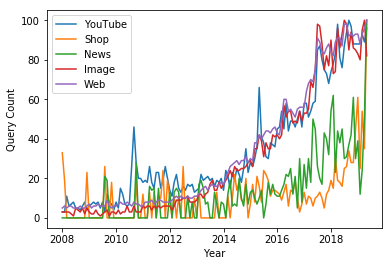

In [7]:
# 월별 노출
plot(googletrend['x_year_month'],googletrend['yt_query'])
plot(googletrend['x_year_month'],googletrend['shop_query'])
plot(googletrend['x_year_month'],googletrend['news_query'])
plot(googletrend['x_year_month'],googletrend['image_query'])
plot(googletrend['x_year_month'],googletrend['web_query'])
legend(['YouTube','Shop','News', 'Image','Web'])
xlabel('Year')
ylabel('Query Count')
plt.show()

### 상관관계

In [8]:
colnames = googletrend.columns
colnames

Index(['year_month', 'year', 'month', 'yt_query', 'shop_query', 'news_query',
       'image_query', 'web_query', 'x_year_month'],
      dtype='object')

In [9]:
# 상관관계를 계산하기 위해서는 변화율이 필요하다.
googletrend_small = googletrend[['yt_query','shop_query','news_query','image_query','web_query']]
nRows = googletrend_small.shape[0]
googletrend_small_m = googletrend_small.iloc[0:nRows-1,]
googletrend_small_p = googletrend_small.iloc[1:nRows,] 
googletrend_small_p.index = np.arange(nRows-1)
googletrend_small_rate = np.log((googletrend_small_p+1)/(googletrend_small_m+1))

In [10]:
corr_data = googletrend_small_rate.corr(method = 'pearson')
np.round(corr_data,2)

,yt_query,shop_query,news_query,image_query,web_query
yt_query,1.00,-0.15,0.00,-0.05,0.15
shop_query,-0.15,1.00,0.33,0.16,-0.19
news_query,0.00,0.33,1.00,0.13,0.00
image_query,-0.05,0.16,0.13,1.00,0.24
web_query,0.15,-0.19,0.00,0.24,1.00


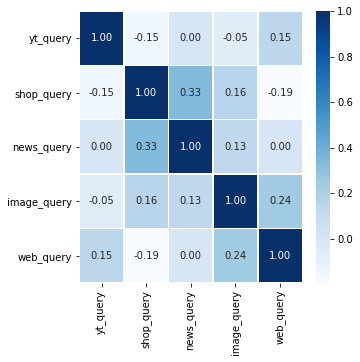

In [11]:
plt.figure(figsize = (5,5))
sns.heatmap(data = corr_data, annot=True, fmt = '.2f', linewidths=.5, cmap = 'Blues')
plt.show()

## Google Trend + 매출데이터

### 데이터 합치기

In [12]:
# 분기로 변환.
quarter = []
for i in range(googletrend.shape[0]):
    if googletrend['month'][i] == 1 :
        quarter.append(1)
    elif googletrend['month'][i] == 2 :
        quarter.append(1)   
    elif googletrend['month'][i] == 3 :
        quarter.append(1)
    elif googletrend['month'][i] == 4 :
        quarter.append(2)
    elif googletrend['month'][i] == 5 :
        quarter.append(2)
    elif googletrend['month'][i] == 6 :
        quarter.append(2)
    elif googletrend['month'][i] == 7 :
        quarter.append(3)
    elif googletrend['month'][i] == 8 :
        quarter.append(3)
    elif googletrend['month'][i] == 9 :
        quarter.append(3)
    elif googletrend['month'][i] == 10 :
        quarter.append(4)
    elif googletrend['month'][i] == 11 :
        quarter.append(4)
    elif googletrend['month'][i] == 12 :
        quarter.append(4)
googletrend['quarter'] = quarter

In [13]:
# 분기별 합계 계산.
google_quarter = googletrend.groupby(['year', 'quarter']).sum()              
google_quarter =google_quarter.drop(columns = ['year_month','month'])           # 불필요 컬럼 삭제.
google_quarter.reset_index(inplace=True)                                        # Multi-index 해제.
google_quarter

,year,quarter,yt_query,shop_query,news_query,image_query,web_query
0,2008,1,17,52,0,9,16
1,2008,2,21,0,0,6,17
2,2008,3,14,0,0,12,16
3,2008,4,18,23,0,12,16
4,2009,1,21,0,0,7,18
5,2009,2,20,0,0,7,19
6,2009,3,23,26,40,9,21
7,2009,4,19,18,0,7,17
8,2010,1,28,0,0,8,21
9,2010,2,25,0,0,12,22


In [14]:
# 데이터 프레임 병합.
google_and_sales = pd.merge(sales, google_quarter,how='inner',on=['year','quarter'])  # Inner join으로 병합.
google_and_sales = google_and_sales.drop(columns=['year_quarter'])
google_and_sales.head(8)

,year,quarter,sales,sales(-china),yt_query,shop_query,news_query,image_query,web_query
0,2010,1,851,646.76,28,0,0,8,21
1,2010,2,703,534.28,25,0,0,12,22
2,2010,3,474,360.24,79,0,0,12,21
3,2010,4,1310,995.60,68,18,28,9,20
4,2011,1,2054,1478.88,55,12,0,17,22
5,2011,2,980,705.60,59,26,45,16,24
6,2011,3,617,444.24,61,20,15,16,26
7,2011,4,857,617.04,65,43,0,18,24


### 분기별 그래프

#### 매출과 노출 추이 (절대 수치)

In [15]:
nRows = google_and_sales.shape[0]
x = []
for i in range(nRows):
    if google_and_sales['quarter'][i] == 1 :
        x.append(datetime(google_and_sales['year'][i],3,1))               # 1분기 => 3월 1일.
    elif google_and_sales['quarter'][i] == 2 :
        x.append(datetime(google_and_sales['year'][i],6,1))               # 2분기 => 6월 1일.
    elif google_and_sales['quarter'][i] == 3 :
        x.append(datetime(google_and_sales['year'][i],9,1))               # 3분기 => 9월 1일.
    elif google_and_sales['quarter'][i] == 4 :
        x.append(datetime(google_and_sales['year'][i],12,1))              # 4분기 => 12월 1일.
google_and_sales['x_year_month'] = x
google_and_sales.head(5)

,year,quarter,sales,sales(-china),yt_query,shop_query,news_query,image_query,web_query,x_year_month
0,2010,1,851,646.76,28,0,0,8,21,2010-03-01
1,2010,2,703,534.28,25,0,0,12,22,2010-06-01
2,2010,3,474,360.24,79,0,0,12,21,2010-09-01
3,2010,4,1310,995.60,68,18,28,9,20,2010-12-01
4,2011,1,2054,1478.88,55,12,0,17,22,2011-03-01


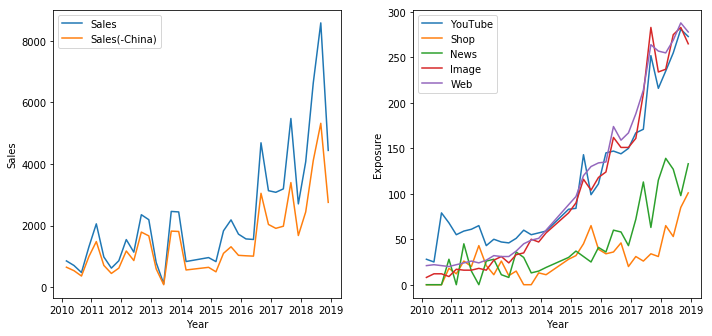

In [16]:
fig = plt.figure(figsize=(10,4))
axes1 = fig.add_axes([0,0,0.4,1])
axes2 = fig.add_axes([0.5,0,0.4,1])
axes1.plot(google_and_sales['x_year_month'],google_and_sales['sales'])
axes1.plot(google_and_sales['x_year_month'],google_and_sales['sales(-china)'])
axes1.legend(['Sales','Sales(-China)'])
axes1.set_xlabel('Year')
axes1.set_ylabel('Sales')
axes2.plot(google_and_sales['x_year_month'],google_and_sales['yt_query'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['shop_query'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['news_query'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['image_query'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['web_query'])
axes2.legend(['YouTube','Shop','News','Image','Web'])
axes2.set_xlabel('Year')
axes2.set_ylabel('Exposure')
plt.show()

#### 매출과 노출 추이 (최대값 대비 비율)

In [17]:
# 최대값 대비 비율로 변환.
ratio_sales = []
ratio_china = []
ratio_yt = []
ratio_shop =[]
ratio_news = []
ratio_image = []
ratio_web =[]
for i in range(nRows):
    ratio_sales.append((google_and_sales['sales'][i]/max(google_and_sales['sales']))*100)
    ratio_china.append((google_and_sales['sales(-china)'][i]/max(google_and_sales['sales(-china)']))*100)
    ratio_yt.append((google_and_sales['yt_query'][i]/max(google_and_sales['yt_query']))*100)
    ratio_shop.append((google_and_sales['shop_query'][i]/max(google_and_sales['shop_query']))*100)
    ratio_news.append((google_and_sales['news_query'][i]/max(google_and_sales['news_query']))*100)
    ratio_image.append((google_and_sales['image_query'][i]/max(google_and_sales['image_query']))*100)
    ratio_web.append((google_and_sales['web_query'][i]/max(google_and_sales['web_query']))*100)
google_and_sales['ratio_sales'] = ratio_sales
google_and_sales['ratio_sales(-china)'] = ratio_china
google_and_sales['ratio_yt'] = ratio_yt
google_and_sales['ratio_shop'] = ratio_shop
google_and_sales['ratio_news'] = ratio_news
google_and_sales['ratio_image'] = ratio_image
google_and_sales['ratio_web'] = ratio_web
google_and_sales = google_and_sales[google_and_sales['year']!=2019]

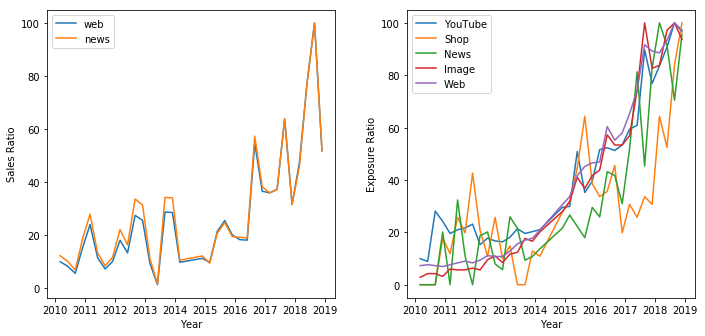

In [18]:
fig = plt.figure(figsize=(10,4))
axes1 = fig.add_axes([0,0,0.4,1])
axes2 = fig.add_axes([0.5,0,0.4,1])
axes1.plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales'])
axes1.plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales(-china)'])
axes1.legend(['web', 'news','youtube','image','shop','sales','sales(-china)'])
axes1.set_xlabel('Year')
axes1.set_ylabel('Sales Ratio')
axes2.plot(google_and_sales['x_year_month'],google_and_sales['ratio_yt'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['ratio_shop'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['ratio_news'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['ratio_image'])
axes2.plot(google_and_sales['x_year_month'],google_and_sales['ratio_web'])
axes2.legend(['YouTube','Shop','News','Image','Web'])
axes2.set_xlabel('Year')
axes2.set_ylabel('Exposure Ratio')
plt.show()

#### YouTube >> 매출

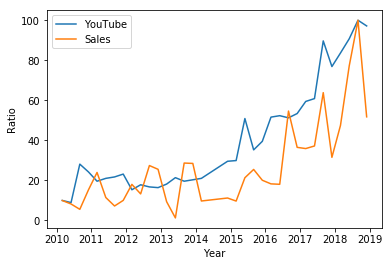

In [19]:
# ratio_sales와 ratio_china는 많이 겹치므로 ratio_china 시각화는 스킵함.
plot(google_and_sales['x_year_month'],google_and_sales['ratio_yt'])
plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales'])
legend(['YouTube','Sales'])
xlabel('Year')
ylabel('Ratio')
plt.show()

#### Shop >> 매출

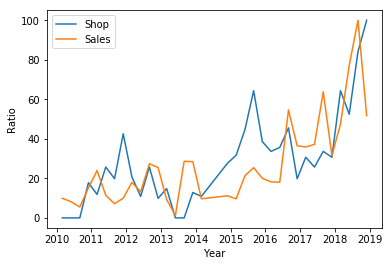

In [20]:
# ratio_sales와 ratio_china는 많이 겹치므로 ratio_china 시각화는 스킵함.
plot(google_and_sales['x_year_month'],google_and_sales['ratio_shop'])
plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales'])
legend(['Shop','Sales'])
xlabel('Year')
ylabel('Ratio')
plt.show()

#### News >> 매출

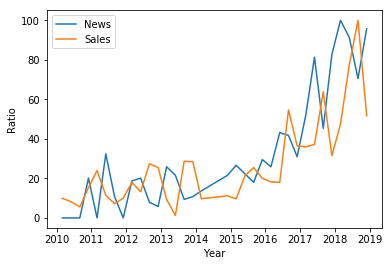

In [21]:
# ratio_sales와 ratio_china는 많이 겹치므로 ratio_china 시각화는 스킵함.
plot(google_and_sales['x_year_month'],google_and_sales['ratio_news'])
plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales'])
legend(['News','Sales'])
xlabel('Year')
ylabel('Ratio')
plt.show()

#### Image >> 매출

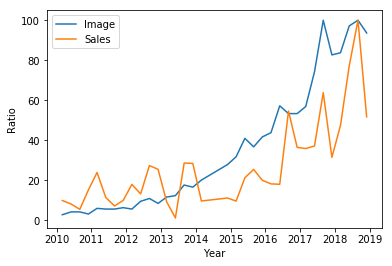

In [22]:
# ratio_sales와 ratio_china는 많이 겹치므로 ratio_china 시각화는 스킵함.
plot(google_and_sales['x_year_month'],google_and_sales['ratio_image'])
plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales'])
legend(['Image','Sales'])
xlabel('Year')
ylabel('Ratio')
plt.show()

#### Web >> 매출

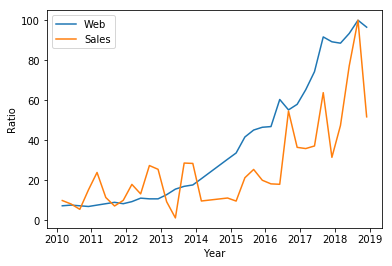

In [23]:
# ratio_sales와 ratio_china는 많이 겹치므로 ratio_china 시각화는 스킵함.
plot(google_and_sales['x_year_month'],google_and_sales['ratio_web'])
plot(google_and_sales['x_year_month'],google_and_sales['ratio_sales'])
legend(['Web','Sales'])
xlabel('Year')
ylabel('Ratio')
plt.show()

### 매출과 노출 사이의 상관관계

In [24]:
google_and_sales.columns

Index(['year', 'quarter', 'sales', 'sales(-china)', 'yt_query', 'shop_query',
       'news_query', 'image_query', 'web_query', 'x_year_month', 'ratio_sales',
       'ratio_sales(-china)', 'ratio_yt', 'ratio_shop', 'ratio_news',
       'ratio_image', 'ratio_web'],
      dtype='object')

In [25]:
# 데이터 간추리기
drop_list=['year','quarter','x_year_month','ratio_sales','ratio_sales(-china)']
drop_list += ['ratio_yt','ratio_shop','ratio_news','ratio_image','ratio_web']
google_and_sales_small=google_and_sales.drop(columns=drop_list)
google_and_sales_small.head(5)

,sales,sales(-china),yt_query,shop_query,news_query,image_query,web_query
0,851,646.76,28,0,0,8,21
1,703,534.28,25,0,0,12,22
2,474,360.24,79,0,0,12,21
3,1310,995.60,68,18,28,9,20
4,2054,1478.88,55,12,0,17,22


In [26]:
# 상관관계를 계산하기 위해서는 변화율이 필요하다.
nRows = google_and_sales_small.shape[0]
google_and_sales_small_m = google_and_sales_small.iloc[0:nRows-1,]
google_and_sales_small_p = google_and_sales_small.iloc[1:nRows,] 
google_and_sales_small_p.index = np.arange(nRows-1)
google_and_sales_small_rate = np.log((google_and_sales_small_p+1)/(google_and_sales_small_m+1))

In [27]:
corr_data = google_and_sales_small_rate.corr(method = 'pearson')
np.round(corr_data,2)

,sales,sales(-china),yt_query,shop_query,news_query,image_query,web_query
sales,1.00,1.00,-0.16,0.37,-0.14,0.13,-0.15
sales(-china),1.00,1.00,-0.15,0.37,-0.13,0.12,-0.16
yt_query,-0.16,-0.15,1.00,-0.04,-0.11,0.15,0.14
shop_query,0.37,0.37,-0.04,1.00,0.24,-0.20,-0.21
news_query,-0.14,-0.13,-0.11,0.24,1.00,-0.43,0.09
image_query,0.13,0.12,0.15,-0.20,-0.43,1.00,0.55
web_query,-0.15,-0.16,0.14,-0.21,0.09,0.55,1.00


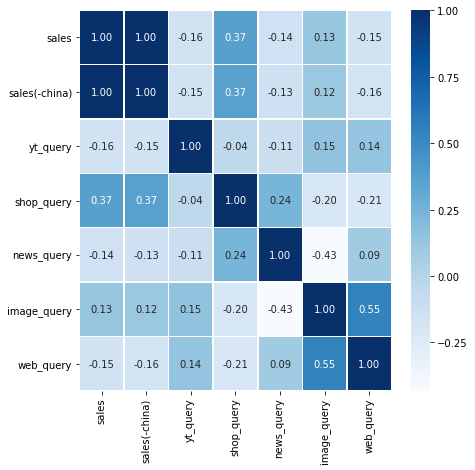

In [28]:
plt.figure(figsize = (7,7))
sns.heatmap(data = corr_data, annot=True, fmt = '.2f', linewidths=.5, cmap = 'Blues')
plt.show()

In [29]:
# 시차 상관계수: YouTube와 Sales
nRows = google_and_sales_small_rate.shape[0]
for d in range(5):
    ser_sales = google_and_sales_small_rate['sales'][d:nRows]
    ser_yt = google_and_sales_small_rate['yt_query'][0:nRows-d]
    corr_val = np.round(ser_sales.corr(ser_yt),2)
    print("Correlation with time difference " + str(d) + " is " + str(corr_val))

Correlation with time difference 0 is -0.16
Correlation with time difference 1 is -0.18
Correlation with time difference 2 is -0.15
Correlation with time difference 3 is -0.13
Correlation with time difference 4 is -0.11


In [30]:
# 2015년도 이후의 상관계수.
google_and_sales_short_rate = google_and_sales_small_rate.iloc[17:,]
corr_data = google_and_sales_short_rate.corr(method = 'pearson')
np.round(corr_data,2)

,sales,sales(-china),yt_query,shop_query,news_query,image_query,web_query
sales,1.00,1.00,0.38,0.46,-0.50,0.33,0.18
sales(-china),1.00,1.00,0.39,0.43,-0.52,0.33,0.16
yt_query,0.38,0.39,1.00,0.05,-0.35,0.66,0.42
shop_query,0.46,0.43,0.05,1.00,-0.08,-0.06,0.09
news_query,-0.50,-0.52,-0.35,-0.08,1.00,-0.11,-0.12
image_query,0.33,0.33,0.66,-0.06,-0.11,1.00,0.81
web_query,0.18,0.16,0.42,0.09,-0.12,0.81,1.00


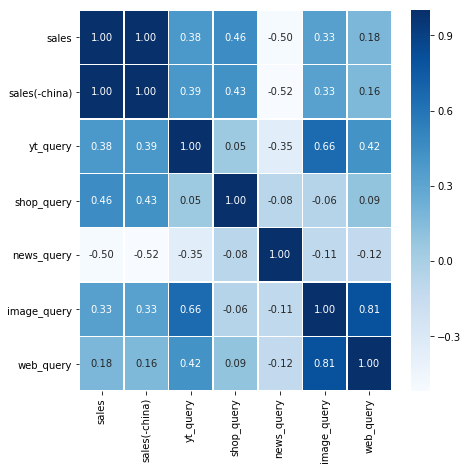

In [31]:
plt.figure(figsize = (7,7))
sns.heatmap(data = corr_data, annot=True, fmt = '.2f', linewidths=.5, cmap = 'Blues')
plt.show()

2015년도 이후 YouTube 조회수와 Sales 사이의 양의 상관성 확인!!!

## YouTube 분석

### 데이터 불러오기

In [32]:
yt = pd.read_csv('fin_0515_data.csv', header = 'infer', encoding = 'UTF-8')
yt_comment = pd.read_csv('fin_0515_comment.csv', header = 'infer', encoding = 'UTF-8')

### YouTube 정량적 분석

#### 동영상 수

In [33]:
yt.shape

(661, 8)

#### View (조회수) 전처리

In [34]:
nRows = yt.shape[0]
drop_list = ['조회수','회',',']
drop_string='|'.join(drop_list)
for i in range(nRows):
    yt['view'][i] = re.sub(drop_string,'',yt['view'][i])
yt['view'] = pd.to_numeric(yt['view'])

#### Date (게시일) 전처리

In [35]:
# 년 / 월로 쪼개기.
x = []
year = []
month = []
drop_list = ['게시일: ','최초 공개: ','\s',':']
drop_string='|'.join(drop_list)
for i in range(nRows):
    yt['date'][i] = re.sub(drop_string,'',yt['date'][i])
    yt['date'][i] = re.sub('실시간스트리밍시작일','',yt['date'][i])
    x = yt['date'][i].split('.')
    year.append(x[0])
    month.append(x[1])
yt['year'] = year
yt['month'] = month
yt['year'] = pd.to_numeric(yt['year'])
yt['month'] = pd.to_numeric(yt['month'])
yt = yt.drop(columns=['date'])

In [36]:
yt.shape
yt.sort_values(by=['year','month']).head(5)

,link,title,view,good,bad,description,number of comment,year,month
53,https://www.youtube.com/watch?v=d3aq49eygaU,Song Hye Kyo Innisfree CF,2936,15,1,Song hye Kyo innisfree CF,댓글 1개,2007,1
1,https://www.youtube.com/watch?v=1xn7rjlOxfc,Celtic Woman - Isle of Inisfree,2134965,4.9천,112,Purchase Info and Tour Dates: http://www.celti...,댓글 512개,2007,5
594,https://www.youtube.com/watch?v=oyfB_fvnJ2g,The Isle Of Innisfree,558583,1.2천,69,The Isle Of Innisfree by The Dublin City Rambl...,댓글 112개,2007,5
156,https://www.youtube.com/watch?v=-A5hbpB94LA,The Isle of Innisfree - Maureen Hegarty,72372,146,2,'The Isle of Innisfree' - Words & Music by Dic...,댓글 93개,2007,11
254,https://www.youtube.com/watch?v=bGPIhN1Z9GA,The Lake Isle Of Innisfree,5173,7,2,Words by William Butler Yeats. Read by our fri...,댓글 1개,2008,4


In [37]:
# 분기로 변환.
quarter = []
a=[1,2,3]
b=[4,5,6]
c=[7,8,9]
for i in range(yt.shape[0]):
    if yt['month'][i] in a :
        quarter.append(1)
    elif yt['month'][i] in b :
        quarter.append(2)
    elif yt['month'][i] in c :
        quarter.append(3)
    else:
        quarter.append(4)
yt['quarter'] = quarter

#### Good (좋아요) 전처리

In [38]:
goodnum = []
for i in range(nRows):
    if yt['good'][i][-1] == '천' :
        goodnum.append(int(float(yt['good'][i][:-1])*1000))
    elif yt['good'][i][-1] == '만' :
        goodnum.append(int(float(yt['good'][i][:-1])*10000))
    elif yt['good'][i] == '좋아요' :
        goodnum.append(0)
    else :
        goodnum.append(int(yt['good'][i]))
yt['good'] = goodnum

#### Bad (싫어요) 전처리

In [39]:
drop_string = '싫어요'
bad = yt['bad']
for i in range(nRows):
    try:
        bad[i] = re.sub(drop_string, '0', bad[i])
        if yt['bad'][i][-1] == '천' :
            bad[i]= (int(float(yt['bad'][i][:-1])*1000))
        elif yt['bad'][i][-1] == '만' :
            bad[i]=  (int(float(yt['bad'][i][:-1])*10000))
    except:
        pass
yt['bad'] = pd.to_numeric(yt['bad'])

#### Good 비율 파생변수

In [40]:
good_ratio = yt['good']/(yt['good']+yt['bad'])
good_ratio = good_ratio.fillna(0)
yt['good_ratio'] = good_ratio

#### Number fo comment (댓글수) 전처리

In [41]:
drop_list = ['댓글','개',',','\s']
drop_string='|'.join(drop_list)
num_com = yt['number of comment']
for i in range(nRows):
    num_com[i] = re.sub(drop_string, '', num_com[i])
yt['number of comment'] = pd.to_numeric(num_com)

#### 다양한 통계치 계산

In [42]:
print("조회수 누적 : " + str(yt['view'].sum()))
print("조회수 평균 : " + str(int(yt['view'].mean())))
print("조회수 중위 : " + str(int(yt['view'].median())))
print('-'*30)
print("댓글수 누적 : " + str(yt['number of comment'].sum()))
print("댓글수 평균 : " + str(int(yt['number of comment'].mean())))
print("댓글수 중위 : " + str(int(yt['number of comment'].median())))
print('-'*30)
print("Good 비율 평균 : " + str(np.round(yt['good_ratio'].mean(),2)))
print("Good 비율 중위 : " + str(np.round(yt['good_ratio'].median(),2)))

조회수 누적 : 105482735
조회수 평균 : 159580
조회수 중위 : 31433
------------------------------
댓글수 누적 : 117856
댓글수 평균 : 178
댓글수 중위 : 41
------------------------------
Good 비율 평균 : 0.92
Good 비율 중위 : 0.97


#### 분기별 동영상 개수

In [43]:
# 별도의 데이터 프레임으로 만든다.
# 카운트가 0이어도 표시.
video_count = []
for i in range(2007,2020):
    for j in range(1,5):
        x = yt.loc[yt['year'] == i][yt['quarter'] == j]['link'].count()
        video_count.append([i , j , x])
video_count = pd.DataFrame(video_count)
video_count.rename(columns = {0:'year',1:'quarter', 2:'video_count'},inplace = True)
video_count.head(10)

,year,quarter,video_count
0,2007,1,1
1,2007,2,2
2,2007,3,0
3,2007,4,1
4,2008,1,0
5,2008,2,2
6,2008,3,2
7,2008,4,1
8,2009,1,1
9,2009,2,3


#### 동영상 개수와 매출 데이터 병합

In [44]:
video_and_sales = pd.merge(sales, video_count, how = 'inner', on=['year','quarter'])
video_and_sales.head(10)

,year_quarter,year,quarter,sales,sales(-china),video_count
0,201001,2010,1,851,646.76,5
1,201002,2010,2,703,534.28,0
2,201003,2010,3,474,360.24,4
3,201004,2010,4,1310,995.60,1
4,201101,2011,1,2054,1478.88,1
5,201102,2011,2,980,705.60,2
6,201103,2011,3,617,444.24,2
7,201104,2011,4,857,617.04,4
8,201201,2012,1,1543,1172.68,2
9,201202,2012,2,1135,862.60,5


### YouTube 정성적 분석

#### 댓글 date 전처리 : 빈칸 및 불필요한 문자 지우기

In [45]:
# date 데이터 전처리
nRows = yt_comment.shape[0]
drop_list = ['전','수정됨','[()]','\s']
drop_string='|'.join(drop_list)
for i in range(nRows):
    yt_comment['date'][i] = re.sub(drop_string,'',yt_comment['date'][i])

#### [확인 필요] 댓글 comment date(video date) 전처리 : 빈칸 및 불필요한 문자 지우기

In [46]:
# comment date 데이터 전처리
comment_date = []
drop_list = ['게시일:','최초공개:','실시간스트리밍시작일:','수정됨','[()]','\s']
drop_string='|'.join(drop_list)
for i in range(nRows):
    yt_comment['comment date'][i] = re.sub(drop_string,'',yt_comment['comment date'][i])
comment_date = []
for i in range(nRows):
    yt_comment['comment date'][i] = re.sub(drop_string,'',yt_comment['comment date'][i])

In [47]:
x = []
comment_date = []
for i in range(nRows) :
    x = yt_comment['comment date'][i].split('.')
    comment_date.append(datetime(int(x[0]),int(x[1]),int(x[2])))
yt_comment['comment date'] = comment_date

#### 댓글 date 년/월/일에 따라 날짜 지정

In [48]:
comment_date = []
for i in range(nRows) :
    if yt_comment['date'][i][-1] == '초' :
        comment_date.append(relativedelta(days = 0))
    elif yt_comment['date'][i][-1] == '분' :
        comment_date.append(relativedelta(days = 0))
    elif yt_comment['date'][i][-1] == '간' :
        comment_date.append(relativedelta(days = 0))
    elif yt_comment['date'][i][-1] == '일' :
        comment_date.append(relativedelta(days = int(yt_comment['date'][i][:-1])))
    elif yt_comment['date'][i][-1] == '주' :
        comment_date.append(relativedelta(weeks = int(yt_comment['date'][i][:-1])))
    elif yt_comment['date'][i][-1] == '월' :
        comment_date.append(relativedelta(weeks = int(yt_comment['date'][i][:-2])*4))
    elif yt_comment['date'][i][-1] == '년' :
        comment_date.append(relativedelta(years = int(yt_comment['date'][i][:-1])))
#comment_date

In [49]:
# 시간 차이를 기록함.
collected_date = datetime(2019,5,15)                     # 기준 일자
in_date = []
for i in range(len(comment_date)):
    in_date.append(collected_date - comment_date[i])
yt_comment['date'] = in_date                            # data 변수 대체

In [50]:
# comment date보다 date가 앞인 경우, comment date로 수정
change_date = []
for i in range(nRows) :
    if yt_comment['date'][i] - yt_comment['comment date'][i] < timedelta(days = 0) :
        change_date.append(yt_comment['comment date'][i])
    else :
        change_date.append(yt_comment['date'][i])     
yt_comment['date'] = change_date

#### 년, 월로 변환

In [51]:
x = []
year = []
month = []
for i in range(len(yt_comment['date'])):
    x = str(yt_comment['date'][i]).split('-')
    year.append(x[0])
    month.append(x[1])
yt_comment['year'] = pd.to_numeric(year)            # 수치형으로 변환 포함!
yt_comment['month'] = pd.to_numeric(month)          # 수치형으로 변환 포함!
yt_comment = yt_comment.drop(columns=['date'])                   # 이제는 중복적이므로 제거!

In [52]:
yt_comment.shape
yt_comment.sort_values(by=['year','month'])

,link,comment,comment date,year,month
3621,https://www.youtube.com/watch?v=d3aq49eygaU,i think so too.,2007-01-31,2007,5
417,https://www.youtube.com/watch?v=1xn7rjlOxfc,"Well, I must tell you, that when I have had en...",2007-05-22,2008,5
418,https://www.youtube.com/watch?v=1xn7rjlOxfc,"i love the tune, i listen to this song everyda...",2007-05-22,2008,5
419,https://www.youtube.com/watch?v=1xn7rjlOxfc,As do the rest of us. =/,2007-05-22,2008,5
420,https://www.youtube.com/watch?v=1xn7rjlOxfc,It might be. Perhaps I'll try it one day.,2007-05-22,2008,5
421,https://www.youtube.com/watch?v=1xn7rjlOxfc,BEAUTIFUL,2007-05-22,2008,5
422,https://www.youtube.com/watch?v=1xn7rjlOxfc,But then it always sounds as if a man would be...,2007-05-22,2008,5
423,https://www.youtube.com/watch?v=1xn7rjlOxfc,"Well I am a Contra alto. That´s pretty bad, be...",2007-05-22,2008,5
424,https://www.youtube.com/watch?v=1xn7rjlOxfc,I sometimes listen to this when I go to sleep....,2007-05-22,2008,5
425,https://www.youtube.com/watch?v=1xn7rjlOxfc,"im a countertenor, i can sometimes reach mezzo...",2007-05-22,2008,5


#### 분기로 변환

In [53]:
quarter = []
for i in range(nRows):
    if yt_comment['month'][i] == 1 :
        quarter.append(1)
    elif yt_comment['month'][i] == 2 :
        quarter.append(1)   
    elif yt_comment['month'][i] == 3 :
        quarter.append(1)
    elif yt_comment['month'][i] == 4 :
        quarter.append(2)
    elif yt_comment['month'][i] == 5 :
        quarter.append(2)
    elif yt_comment['month'][i] == 6 :
        quarter.append(2)
    elif yt_comment['month'][i] == 7 :
        quarter.append(3)
    elif yt_comment['month'][i] == 8 :
        quarter.append(3)
    elif yt_comment['month'][i] == 9 :
        quarter.append(3)
    elif yt_comment['month'][i] == 10 :
        quarter.append(4)
    elif yt_comment['month'][i] == 11 :
        quarter.append(4)
    elif yt_comment['month'][i] == 12 :
        quarter.append(4)
yt_comment['quarter'] = quarter

### 댓글의 탐색적 분석

#### 댓글 전처리

In [54]:
com = yt_comment['comment']
n_min = 3                                                           # 최소 문자 개수. 
corpus_com = []
lemmatizer = WordNetLemmatizer()
for line in com:
    pre = re.sub(r'\W', ' ', str(line))                                  # 특수문자 제외. Space로 대체!
    pre = re.sub(r'_', ' ', pre)                                    # 특수문자 제외. Space로 대체!
    pre = re.sub(r'\d+','', pre)                                    # 숫자제외
    pre = re.sub(r'이니스프리','', pre)  
    pre = re.sub(r'innisfree','', pre)
    pre = re.sub(r'Innisfree','', pre)
    pre = pre.lower()
    pre = nltk.word_tokenize(pre)
    pre = [x for x in pre if len(x) > n_min]                        # 최소 길이 충족.
    pre = [x for x in pre if x not in stopwords.words('english')]   # 불용어 처리.
    pre = [lemmatizer.lemmatize(x) for x in pre]                    # 원형 복원.
    corpus_com += pre   

In [55]:
len(corpus_com)

268770

#### 단어 빈도 카운팅

In [56]:
freq = nltk.FreqDist(corpus_com)
freq_top = freq.most_common(20)
freq_top

[('love', 3796),
 ('video', 3325),
 ('skin', 2465),
 ('like', 1982),
 ('product', 1949),
 ('really', 1526),
 ('review', 1437),
 ('look', 1273),
 ('yoona', 1172),
 ('make', 1131),
 ('thank', 1101),
 ('good', 1067),
 ('please', 1038),
 ('beautiful', 1008),
 ('much', 995),
 ('would', 936),
 ('thanks', 899),
 ('mask', 876),
 ('makeup', 831),
 ('know', 743)]

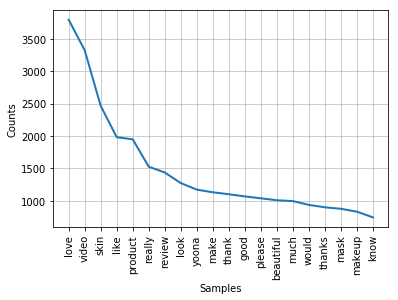

In [57]:
# 시각화
freq.plot(20)

#### Biagram 빈도 카운팅

In [58]:
bigrams = nltk.bigrams(corpus_com)
freq_bi = nltk.FreqDist(bigrams)
freq_bi_top = freq_bi.most_common(20)
freq_bi_top

[(('love', 'video'), 345),
 (('would', 'love'), 257),
 (('oily', 'skin'), 257),
 (('skin', 'care'), 245),
 (('look', 'like'), 218),
 (('thank', 'much'), 174),
 (('yoona', 'yoona'), 162),
 (('green', 'seed'), 153),
 (('etude', 'house'), 152),
 (('sheet', 'mask'), 149),
 (('really', 'love'), 144),
 (('would', 'like'), 141),
 (('clay', 'mask'), 140),
 (('love', 'love'), 138),
 (('seed', 'serum'), 135),
 (('mama', 'anne'), 135),
 (('make', 'video'), 126),
 (('care', 'routine'), 125),
 (('watching', 'video'), 124),
 (('love', 'much'), 119)]

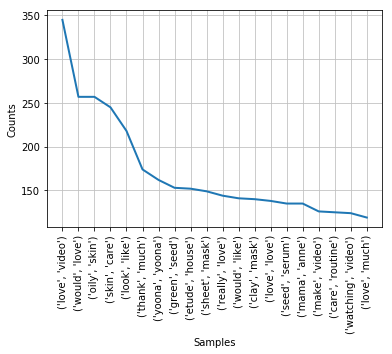

In [59]:
# 시각화
freq_bi.plot(20)

#### trigram 빈도 카운팅

In [60]:
trigrams = nltk.trigrams(corpus_com)
freq_tri = nltk.FreqDist(trigrams)
freq_tri_top = freq_tri.most_common(20)
freq_tri_top

[(('green', 'seed', 'serum'), 106),
 (('yoona', 'yoona', 'yoona'), 88),
 (('bija', 'cica', 'balm'), 75),
 (('acne', 'prone', 'skin'), 66),
 (('would', 'love', 'green'), 61),
 (('skin', 'care', 'product'), 54),
 (('skin', 'care', 'routine'), 51),
 (('please', 'make', 'video'), 40),
 (('volcanic', 'clay', 'mask'), 35),
 (('pore', 'clay', 'mask'), 35),
 (('overnight', 'care', 'routine'), 33),
 (('korean', 'skin', 'care'), 32),
 (('keep', 'good', 'work'), 31),
 (('volcanic', 'pore', 'clay'), 30),
 (('love', 'love', 'love'), 29),
 (('chala', 'baga', 'chepparu'), 28),
 (('ready', 'makeup', 'routine'), 27),
 (('brenda', 'would', 'love'), 26),
 (('oily', 'acne', 'prone'), 25),
 (('super', 'volcanic', 'pore'), 25)]

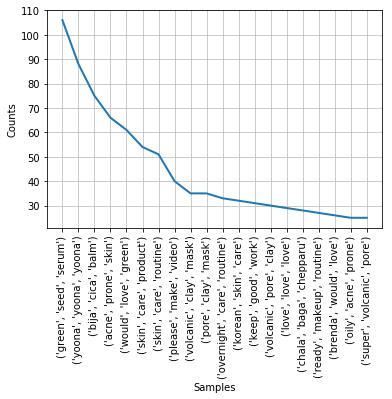

In [61]:
freq_tri.plot(20)

#### 분기별 댓글 개수

In [62]:
# 별도의 데이터 프레임으로 만든다.
# 카운트가 0이어도 표시.
comment_count = []
for i in range(2010,2020):
    for j in range(1,5):
        x = yt_comment.loc[yt_comment['year'] == i][yt_comment['quarter'] == j]['link'].count()
        comment_count.append([i , j , x])
comment_count = pd.DataFrame(comment_count)
comment_count.rename(columns = {0:'year',1:'quarter', 2:'comment_count'},inplace = True)
comment_count.head(10)

,year,quarter,comment_count
0,2010,1,0
1,2010,2,133
2,2010,3,0
3,2010,4,0
4,2011,1,0
5,2011,2,252
6,2011,3,0
7,2011,4,0
8,2012,1,0
9,2012,2,389


#### 동영상 개수, 댓글 개수, 매출 데이터 병합

In [63]:
comment_video_and_sales = pd.merge(video_and_sales, comment_count, how = 'inner', on=['year','quarter'])
comment_video_and_sales.head(10)

,year_quarter,year,quarter,sales,sales(-china),video_count,comment_count
0,201001,2010,1,851,646.76,5,0
1,201002,2010,2,703,534.28,0,133
2,201003,2010,3,474,360.24,4,0
3,201004,2010,4,1310,995.60,1,0
4,201101,2011,1,2054,1478.88,1,0
5,201102,2011,2,980,705.60,2,252
6,201103,2011,3,617,444.24,2,0
7,201104,2011,4,857,617.04,4,0
8,201201,2012,1,1543,1172.68,2,0
9,201202,2012,2,1135,862.60,5,389


### 워드 클라우드 생성 

In [64]:
# 일단 하나의 문자열로 엮어둔다.
com_corpus = ' '.join(corpus_com)

In [65]:
# WordCloud 생성.
wc = WordCloud(background_color='white', max_words=50)              # 바탕색, 단어 개수 등 설정.
wc.generate(com_corpus)
# wc.words_

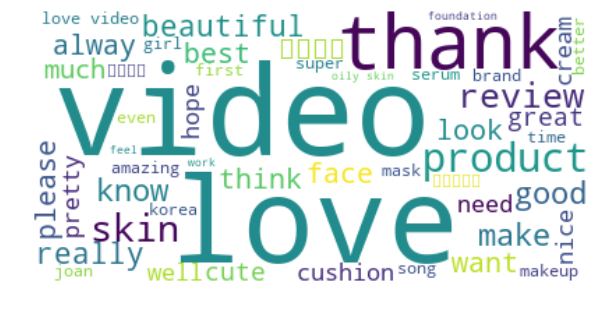

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")                                    # 축을 꺼줌.
plt.show()

## Twitter 데이터 분석

### 데이터 불러오기

In [3]:
tweets = pd.read_csv('twitter_0516_fin.csv', header = 'infer', encoding = 'UTF-8')
tweets.columns = ['tweets','date','id']

In [4]:
tweets

,tweets,date,id
0,20190503\r\n여자친구 GFRIEND / 소원 Sowon & 예린 Yerin...,5월 6일,@Regammamusic
1,190513 Innisfree WEIBO 주정팅\r\n\r\n\r\n\r\n#주정팅...,5월 13일,@ELLE_318
2,고객님+국프님들이 미세먼지속에서도 웃으셨으면 해서더 노력하겠습니다,5월 4일,@ecoinnisfree
3,연인이나 아주 가까운 친구라도 굳이 알 필요가 없는 건 안 말해도 된다,1일,@innisfree54
4,귀여워ㅜㅜ,1일,@innisfree54
5,워너원 굿즈 옹성우 강다니엘 양도\r\n#워너원굿즈\r\n\r\nWANNAONE G...,1일,@young2eyo
6,오빠가 용돈 줌 늦은 생일선물이라구,2일,@innisfree54
7,"오펀 블랙은 스토리,세계관, 캐릭터, 관계 전복, 텐션 등등 다 훌륭하지만 특히나 ...",2일,@innisfree54
8,"실력이 없으면 착하기라도 하던가, 눈치라도 있던가,,,어디서 반 세기도 더 된 이론...",5월 13일,@innisfree54
9,연합동아리에서 나이 많고 자존심 쎈 자칭 ^고학력 남성^인 운영위원이 나한테\r\n...,5월 13일,@innisfree54


### 작성날짜 전처리

#### 한국어 제거

In [5]:
tweets2 = tweets.copy()

# 한글처리된거 먼저 제거
tweets2 = tweets2['tweets'].apply(lambda x: re.sub('[^가-힣]',' ',str(x)).strip())
tweets = tweets.iloc[tweets2[tweets2.str.len()== 0].index]

# http 제거
tweets['tweets'] = tweets['tweets'].apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', str(x)))

# 영어만 남기기. 특수문자 제거
tweets['tweets'] = tweets['tweets'].apply(lambda x: re.sub('[^a-zA-Z]',' ',str(x)).strip())

#### 분기로 변경

In [6]:
# 날짜 관련 함수 정의
def twitterDateProcessing(date):
    if(len(date) < 8):
        return ('2019년 ' + date)
    else:
        return date

In [7]:
# 년도 안 붙어 있는 날짜 처리
tweets['date'] = tweets['date'].apply(lambda x: twitterDateProcessing(x))

# 공백 제거
# 날짜가 이상한거 제거 ex) 1일, 2일 월도없이 중간중간에 있는것들
tweets = tweets[(tweets['tweets'] != '') & (tweets['date'].str.len() >= 10)]

# 날짜 처리
tweets['date'] = tweets['date'].apply(lambda x: x.replace('년 ','/'))
tweets['date'] = tweets['date'].apply(lambda x: x.replace('월 ','/'))
tweets['date'] = tweets['date'].apply(lambda x: x.replace('일',''))
tweets['date'] = tweets['date'].apply(lambda x: datetime.strptime("/".join(re.findall('\d+', x)), '%Y/%m/%d').strftime('%Y%m%d'))
tweets['year'] = tweets['date'].apply(lambda x: x[0:4])
tweets['month'] = tweets['date'].apply(lambda x: x[4:6])

# 분기 추가
tweets['quarter'] = tweets['month'].apply(lambda x: ((int(x)-1)//3 + 1))

### Tweet의 탐색적 분석

In [106]:
tw = tweets['tweets']
n_min = 3                                                           # 최소 문자 개수. 
corpus_tw = []
lemmatizer = WordNetLemmatizer()
for line in tw:
    pre = re.sub(r'\W', ' ', str(line))                                # 특수문자 제외.
    pre = re.sub(r'_', ' ', pre)                                    # 특수문자 제외.
    pre = re.sub(r'\d+','', pre)                                    # 숫자제외
    pre = re.sub(r'이니스프리','', pre)   
    pre = re.sub(r'innisfree','', pre)
    pre = re.sub(r'นะคะ','',pre)
    pre = re.sub(r'Innisfree','', pre)
    pre = pre.lower()
    pre = nltk.word_tokenize(pre)
    pre = [x for x in pre if len(x) > n_min]                        # 최소 길이 충족.
    pre = [x for x in pre if x not in stopwords.words('english')]   # 불용어 처리.
    pre = [lemmatizer.lemmatize(x) for x in pre]                    # 원형 복원.
    corpus_tw += pre    

In [107]:
len(corpus_tw)

22174

#### 단어 빈도 카운팅

In [108]:
freq = nltk.FreqDist(corpus_tw)
freq.most_common(20)                        # 'ลาเนจ' = '라네즈',  'ราคา' = '가격'
for i,j in enumerate(freq.most_common(20)) :
    print(f'{i}: {j}')

0: ('yoona', 466)
1: ('http', 402)
2: ('mask', 258)
3: ('wannaone', 157)
4: ('howtoperfect', 142)
5: ('green', 140)
6: ('innisfree', 127)
7: ('clay', 125)
8: ('giveaway', 120)
9: ('jeju', 108)
10: ('serum', 103)
11: ('snsd', 100)
12: ('volcanic', 95)
13: ('like', 85)
14: ('event', 80)
15: ('twitter', 79)
16: ('weibo', 75)
17: ('seed', 72)
18: ('skin', 72)
19: ('product', 70)


#### Biagram 빈도 카운팅

In [77]:
bigrams = nltk.bigrams(corpus_tw)
freq_bi = nltk.FreqDist(bigrams)
freq_bi.most_common(20)

[(('clay', 'mask'), 88),
 (('snsd', 'yoona'), 84),
 (('http', 'sinaimg'), 69),
 (('sinaimg', 'large'), 67),
 (('seed', 'serum'), 62),
 (('green', 'seed'), 61),
 (('yoona', 'http'), 48),
 (('http', 'youtu'), 46),
 (('http', 'instagram'), 43),
 (('weibo', 'update'), 42),
 (('jeju', 'volcanic'), 41),
 (('http', 'facebook'), 41),
 (('sheet', 'mask'), 41),
 (('nine', 'percent'), 39),
 (('lake', 'isle'), 38),
 (('yoona', 'promotion'), 36),
 (('color', 'clay'), 35),
 (('super', 'volcanic'), 33),
 (('http', 'twitter'), 32),
 (('http', 'staticflickr'), 28)]

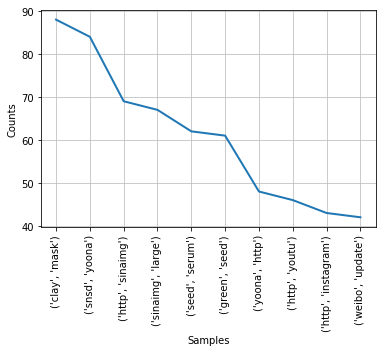

In [78]:
freq_bi.plot(10)

#### trigram 빈도 카운팅

In [79]:
trigrams = nltk.trigrams(corpus_tw)
freq_tri = nltk.FreqDist(trigrams)
freq_tri_top = freq_tri.most_common(20)
freq_tri_top

[(('http', 'sinaimg', 'large'), 67),
 (('green', 'seed', 'serum'), 54),
 (('color', 'clay', 'mask'), 34),
 (('snsd', 'yoona', 'promotion'), 33),
 (('volcanic', 'pore', 'clay'), 21),
 (('arise', 'small', 'cabin'), 21),
 (('small', 'cabin', 'build'), 21),
 (('cabin', 'build', 'clay'), 21),
 (('build', 'clay', 'wattle'), 21),
 (('clay', 'wattle', 'made'), 21),
 (('calendar', 'wallpaper', 'http'), 21),
 (('http', 'image', 'upload'), 21),
 (('pore', 'clay', 'mask'), 20),
 (('http', 'youtube', 'watch'), 20),
 (('super', 'volcanic', 'pore'), 19),
 (('sebum', 'mineral', 'powder'), 19),
 (('jeju', 'volcanic', 'color'), 19),
 (('volcanic', 'color', 'clay'), 19),
 (('http', 'scontent', 'fbcdn'), 18),
 (('wallpaper', 'http', 'baidu'), 18)]

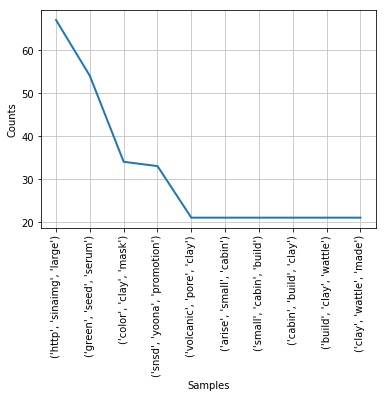

In [80]:
#시각화
freq_tri.plot(10)

### 워드 클라우드 생성 

In [81]:
tw_corpus = ' '.join(corpus_tw)
wc = WordCloud(background_color='white', max_words=30)              # 바탕색, 단어 개수 등 설정.
wc.generate(tw_corpus)
#wc.words_

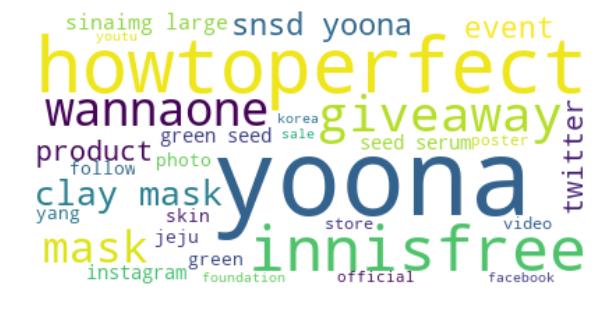

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")                                    # 축을 꺼줌.
plt.show()

# (하는 중)모델링

## 변수선택

## 모델 구축

## 2차 모델 (구글 트렌드 포함)

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [84]:
df1 = pd.merge(video_count, comment_count, how='inner', on=['year','quarter'])
df2 = pd.merge(sales, df1, how='inner', on=['year','quarter'])
df3 = pd.merge(df2, google_quarter, how='inner', on=['year','quarter'])
df3.to_excel('f_sales.xlsx')
df3.head(3)

,year_quarter,year,quarter,sales,sales(-china),video_count,comment_count,yt_query,shop_query,news_query,image_query,web_query
0,201001,2010,1,851,646.76,5,0,28,0,0,8,21
1,201002,2010,2,703,534.28,0,133,25,0,0,12,22
2,201003,2010,3,474,360.24,4,0,79,0,0,12,21


In [85]:
# 데이터를 간추린다.
df = df3.drop(columns=['year_quarter','year','quarter','sales(-china)'])
df.head(5)

,sales,video_count,comment_count,yt_query,shop_query,news_query,image_query,web_query
0,851,5,0,28,0,0,8,21
1,703,0,133,25,0,0,12,22
2,474,4,0,79,0,0,12,21
3,1310,1,0,68,18,28,9,20
4,2054,1,0,55,12,0,17,22


In [86]:
# 데이터를 통계적으로 요약한다.
df.describe()

,sales,video_count,comment_count,yt_query,shop_query,news_query,image_query,web_query
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,2302.735294,14.000000,1032.264706,113.647059,29.323529,43.970588,102.088235,110.588235
std,1877.547938,14.124983,2632.986509,76.996608,23.850190,40.983726,93.214763,93.178915
min,106.000000,0.000000,0.000000,25.000000,0.000000,0.000000,8.000000,20.000000
25%,882.500000,3.250000,0.000000,55.500000,12.250000,15.000000,19.500000,28.000000
50%,1774.000000,6.500000,0.000000,81.000000,26.000000,30.500000,68.000000,74.000000
75%,2984.000000,24.750000,190.750000,149.250000,38.250000,59.500000,158.500000,172.250000
max,8577.000000,49.000000,11498.000000,281.000000,101.000000,139.000000,283.000000,288.000000


In [87]:
# 상관관계를 계산하기 위해서는 변화율이 필요하다.
nRows = df.shape[0]
df_m = df.iloc[0:nRows-1,]
df_p = df.iloc[1:nRows,] 
df_p.index = np.arange(nRows-1)
df_rate = np.log((df_p+1)/(df_m+1))
df_small_rate = df_rate.iloc[17:,]                    # 2015년도 이후만 가져온다!!!!!

In [88]:
np.round(df_small_rate.corr(),2)

,sales,video_count,comment_count,yt_query,shop_query,news_query,image_query,web_query
sales,1.00,0.31,-0.15,0.38,0.46,-0.50,0.33,0.18
video_count,0.31,1.00,-0.24,-0.30,0.30,-0.04,-0.15,-0.27
comment_count,-0.15,-0.24,1.00,0.20,-0.26,0.42,0.46,0.34
yt_query,0.38,-0.30,0.20,1.00,0.05,-0.35,0.66,0.42
shop_query,0.46,0.30,-0.26,0.05,1.00,-0.08,-0.06,0.09
news_query,-0.50,-0.04,0.42,-0.35,-0.08,1.00,-0.11,-0.12
image_query,0.33,-0.15,0.46,0.66,-0.06,-0.11,1.00,0.81
web_query,0.18,-0.27,0.34,0.42,0.09,-0.12,0.81,1.00


### 회귀분석

In [89]:
# X와 Y 변수를 가져온다.
X = df_small_rate.drop(columns=['sales'])
Y = df_small_rate['sales']
Y = np.array(Y)
Y = Y.reshape(-1, 1)

In [90]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [91]:
header = X.columns
pd.DataFrame(lm.coef_,index=['Value'],columns=header)

,video_count,comment_count,yt_query,shop_query,news_query,image_query,web_query
Value,0.250105,0.004289,-0.074811,0.60459,-0.647729,2.318509,-2.294474


In [92]:
# 예측.
Y_pred = lm.predict(X)

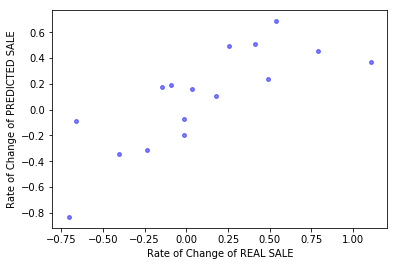

In [93]:
plt.scatter(Y,Y_pred,c = 'blue', s=15, alpha=0.5)
plt.xlabel('Rate of Change of REAL SALE')
plt.ylabel('Rate of Change of PREDICTED SALE')
plt.show()

In [94]:
# 결정계수
np.round(lm.score(X,Y),2)

0.62

### 2차 모델

# [오류] (하는중) 유튜브 댓글 모델링

## 댓글 변수 kmeans 클러스터링

In [ ]:
com = list(com)

In [ ]:
yt_com = []
lemmatizer = WordNetLemmatizer()
for line in com:
    pre = re.sub(r'\W', ' ', str(line))                                  # 특수문자 제외. Space로 대체!
    pre = re.sub(r'_', ' ', pre)                                    # 특수문자 제외. Space로 대체!
    pre = re.sub(r'\d+','', pre)                                    # 숫자제외
    pre = re.sub(r'이니스프리','', pre)  
    pre = re.sub(r'innisfree','', pre)
    pre = lemmatizer.lemmatize(pre)
    pre = pre.lower()                                      
    yt_com.append(pre)     

### TF-IDF 생성

In [ ]:
vectorizer = TfidfVectorizer(max_features = 5000, min_df = 0.01, max_df = 0.99, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(yt_com).toarray()

In [ ]:
print(X)

### 단어 확인

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
print(X[5])

### 코사인 유사도 생성 

In [ ]:
X = 1 - np.round(pairwise_distances(X, metric="cosine"),3)

### kmeans 모델링 

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

#### 클러스터 별 댓글 갯수 확인

In [ ]:
pd.Series(kmeans.labels_).value_counts()

#### 클러스터 별 댓글 확인

In [ ]:
# 총 다큐먼트 갯수 
len(kmeans.labels_)

In [ ]:
#res = pd.Series(kmeans.labels_)
#print(f'cluster 1 = {pd.DataFrame(yt_com)[res==1]}')

In [ ]:
res = pd.Series(kmeans.labels_)
list= []
for i in range(0,3) : 
    print(f'cluster {i} =')
    print(pd.DataFrame(yt_com)[res==i])